In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import bz2
from transformers import T5ForConditionalGeneration, T5Tokenizer, BartForConditionalGeneration, BartTokenizer, pipeline
import torch
import copy
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Embedding, GRU
from tensorflow.keras.models import Sequential, save_model, load_model
from keras.callbacks import ModelCheckpoint
import json
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import plotly.offline as pyo
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random

# Loading data

In [3]:
train_df = pd.read_csv("/kaggle/input/amazon-reviews-cleaned/amazon_reviews_train_cleaned.csv")
test_df = pd.read_csv("/kaggle/input/amazon-reviews-cleaned/amazon_reviews_test_cleaned.csv")

In [4]:
train_df['label'] = train_df['label'] - 1
test_df['label'] = test_df['label'] - 1

In [6]:
train_df['text'] = train_df['title'] + " " + train_df['description']
test_df['text'] = test_df['title'] + " " + test_df['description']

In [7]:
train_df.drop(["Unnamed: 0"], axis=1, inplace=True)
test_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [16]:
train_df = train_df.dropna()
test_df = test_df.dropna()

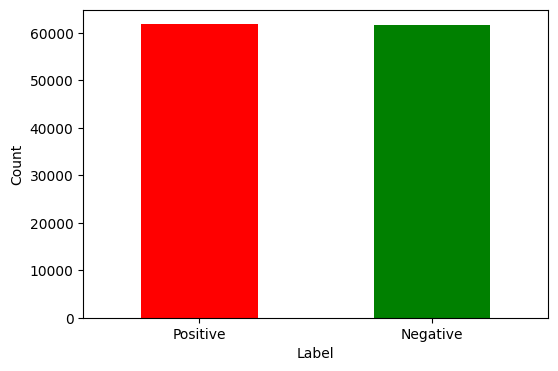

In [17]:
label_counts = train_df['label'].replace({0: 'Negative', 1: 'Positive'}).value_counts()
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [27]:
df_copy = train_df.replace({0: 'Negative', 1: 'Positive'}).copy()
title = get_multi_line_title(
    'Sentiment Distribution',
    "What are the sentiments of the Products Reviews?"
)

sentiment_pie = pd.DataFrame(df_copy['label'].value_counts() / df_copy.shape[0]*100).reset_index()
sentiment_pie.columns = ['label', 'Percentage']
fig = px.pie(sentiment_pie, values='Percentage', names='label', title=title)

fig.update_traces(marker=dict(colors=['#00adb5', '#f8b195', '#f67280']), textposition='inside')
fig.update_layout(
    title=title,
    title_x=0.48,
    template='plotly_dark',
    font=dict(
        family='Arial',
        size=20,  
        color='white'
    ),
    height=700,
    legend=dict(
        title='',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(
            family='Arial',
            size=12,
            color='white'
        )
    )
)
fig.show()


In [30]:
def get_multi_line_title(title, subtitle):
    return f"{title}<br><sub>{subtitle}</sub>"

In [23]:
df_copy = train_df.replace({0: 'Negative', 1: 'Positive'}).copy()
df_copy['sentence_length_by_character'] = df_copy.description.apply(len)
title = get_multi_line_title("Sentence Length Distribution", "Distribution of number of characters per review, by label")

data = df_copy[df_copy['description'].apply(len) != 0]
top_devices = data.groupby('label')['description'].count().sort_values(ascending=False)[:5].index.tolist()
data = data[data['label'].apply(lambda x: x in top_devices)]

fig = px.histogram(data, x="sentence_length_by_character", color="label", opacity=0.75)

fig.update_layout(
    title=title,
    xaxis_title="Number of Characters per Review",
    yaxis_title="Count",
    template="plotly_dark",
    legend_title_text="Language",
    font=dict(
        family="Arial",
        size=16,
        color="white"
    ),
    hoverlabel=dict(
        font=dict(
            family="Arial",
            size=16,
            color="white"
        )
    )
)

fig.show()

In [24]:
def number_of_words(sentence):
    return len(sentence.split())

In [26]:
df_copy = train_df.replace({0: 'Negative', 1: 'Positive'}).copy()
df_copy['sentence_length_by_word'] = df_copy.description.apply(len)
title = get_multi_line_title("Sentence Length Distribution", "Distribution of number of words per review, by label")

data = df_copy[df_copy['description'].apply(number_of_words) != 0]
top_devices = data.groupby('label')['description'].count().sort_values(ascending=False)[:5].index.tolist()
data = data[data['label'].apply(lambda x: x in top_devices)]

fig = px.histogram(data, x="sentence_length_by_word", color="label", opacity=0.75)

fig.update_layout(
    title=title,
    xaxis_title="Number of Words per Review",
    yaxis_title="Count",
    template="plotly_dark",
    legend_title_text="Language",
    font=dict(
        family="Arial",
        size=16,
        color="white"
    ),
    hoverlabel=dict(
        font=dict(
            family="Arial",
            size=16,
            color="white"
        )
    )
)

fig.show()

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
positive_texts = train_df[train_df['label'] == 1]['text']
negative_texts = train_df[train_df['label'] == 0]['text']

positive_counts = vectorizer.fit_transform(positive_texts)
negative_counts = vectorizer.transform(negative_texts)

positive_word_counts = positive_counts.sum(axis=0).A1
negative_word_counts = negative_counts.sum(axis=0).A1

words = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({
    'word': words,
    'positive_count': positive_word_counts,
    'negative_count': negative_word_counts
})

word_freq_df['diff'] = word_freq_df['positive_count'] - word_freq_df['negative_count']
word_freq_df['abs_diff'] = word_freq_df['diff'].abs()

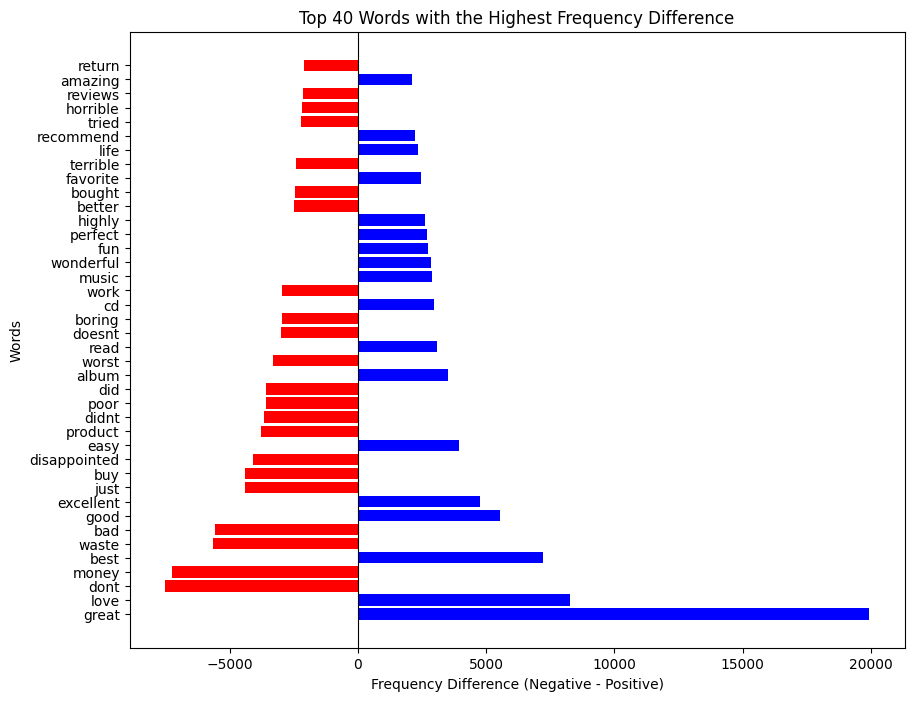

In [40]:
top_words = word_freq_df.nlargest(40, 'abs_diff')

plt.figure(figsize=(10, 8))
plt.barh(top_words['word'], top_words['diff'], color=top_words['diff'].apply(lambda x: 'red' if x < 0 else 'blue'))
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Frequency Difference (Negative - Positive)')
plt.ylabel('Words')
plt.title('Top 40 Words with the Highest Frequency Difference')
plt.show()